# E1. 인공지능과 가위바위보 하기

가위바위보 데이터셋을 직접 구축하여 모델을 만들고 평가할 것이다.

목차는 다음과 같다.

1. 데이터셋 정의 및 전처리
2. 모델 정의 및 학습
3. 하이퍼 파라미터 튜닝
4. 결론

## 1. 데이터셋 정의 및 전처리

[Teachable Machine](https://teachablemachine.withgoogle.com/)을 통해 직접 웹캠을 통해 데이터셋을 만들었다. Teachable Machine을 많이 사용해봤지만 만든 데이터셋을 다운받을 수 있는지는 몰랐다.

![Teachable Machine sample download](./assets/teachable_machine.png)

그렇게 "가위", "바위", "보" 총 약 300장의 데이터를 모았다.

![images](./assets/images.png)

나는 이제 데이터를 가지고 있다. 데이터에 대해서 해야할 일은 다음과 같다.

1. 이미지 데이터 읽기
2. 필요하다면 전처리


**라이브러리 불러오기**

In [1]:
from PIL import Image
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import glob

**이미지 데이터 읽기**

노드에 있는 기존 `resize_images` 함수와 `load_data` 함수를 합쳐서 사용했습니다.

- `resize_images` 라는 함수가 하던 역할인 이미지 resize는 `load_data` 함수안에 `image.resize`를 통해 구현했습니다.
- `load_data` 함수에서 중복되는 코드를 제거하도록 노력하였습니다.
- `load_data` 에서 number_of_data 때문에 이미지 개수가 제한되는 문제점을 해결하였습니다.


**필요하다면 전처리..!!**



In [2]:
def preprocessing(image):
    # 필요하다면 전처리를 한다고 했던 부분이다.
    
    # 업데이트 해 나가보자
    return image

In [3]:
def load_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    images = []
    labels = []
    for idx, category in enumerate(['scissor', 'rock', 'paper']):
        for file in glob.iglob(os.path.join(img_path, category, '*.jpg')):
            image = cv2.imread(file)
            
            # 데이터 전처리
            image = preprocessing(image)

            numpy_image = np.array(image)
            images.append(numpy_image)
            labels.append(idx)
    images = np.array(images, dtype="float")
    images = images / 255.0
    labels = np.array(labels)
    return images, labels

이미지 전처리하고 데이터를 확인하는 과정이 자주 나올것이다. 이를 위해 함수를 하나 만들어두자.


In [4]:
def image_show():
    image_dir_path = './data_all_users/준일/'
    X, y = load_data(image_dir_path)

    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        rand = np.random.choice(range(len(X)))
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[rand], cmap=plt.cm.binary)
        plt.xlabel(y[rand], color='red')
    plt.show()

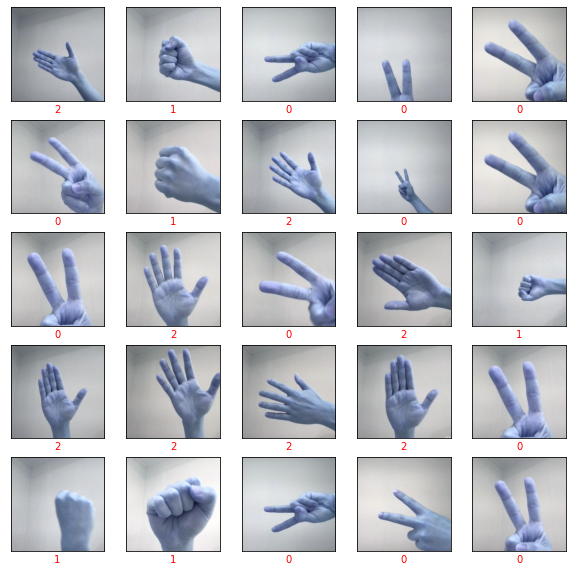

In [5]:
image_show()

아무런 전처리를 하지 않았는데 색이 이상하게 나왔다. 이는 OpenCV에서의 색 영역 표현방식이 "BGR"이기 때문이다. `preprocessing` 에서 이를 변경해보자. 아, 내가 노드와 조금 다르게 OpenCV를 이용한 이유는 조금 있다가 나온다.

In [6]:
def preprocessing(image):
    # 필요하다면 전처리를 한다고 했던 부분이다.
    
    # BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

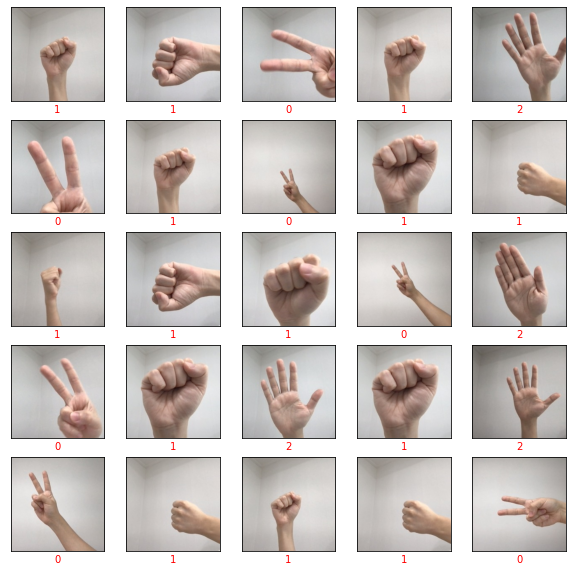

In [7]:
image_show()

---
### 테스트 데이터의 문제점들

내가 @정식님의 데이터를 사용한 것은 가장 배경이 깔끔하다고 생각해서이다. 하지만 테스트로 사용할 다른 사람들의 데이터를 확인해보자.

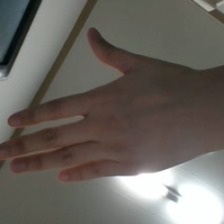

이렇게 손이 위치하는 부분 뒤편에 조명이 있으면 영향을 끼칠 수 있겠단 생각도 하고

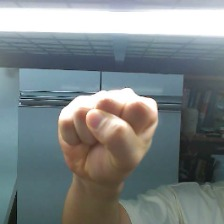

이렇게 사진의 윗부분에 있는 조명과 그로인한 주먹 윗부분의 너무 밝은색 등의 요소들이 문제가 될거라 생각이 들었다. 이를 해결하기 위해서 고민을 해봤는데, `E12. 파이썬으로 이미지 파일 다루기` 에서 배운 mask를 만들고 bitwise 연산을 하는 과정이 생각났다.

In [8]:
def preprocessing(image):
    # 필요하다면 전처리를 한다고 했던 부분이다.
    
    # BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # hand bitwise
    lower_hand = np.array([110,90,80])
    upper_hand = np.array([190,160,150])

    mask = cv2.inRange(image, lower_hand, upper_hand)

    image = cv2.bitwise_and(image, image, mask=mask)
    

    return image

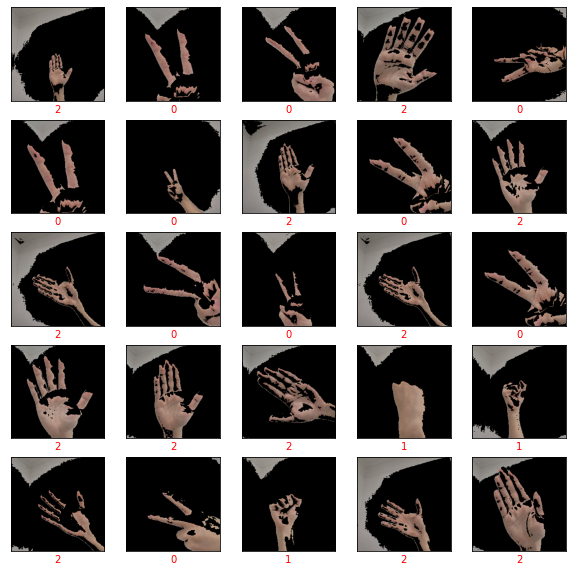

In [9]:
image_show()

주변의 하얀 공간들이 분명 신경쓰일 것이다. 보통 조명이 위쪽에 있기 때문에 그부분이 밝아서 그렇게 된 것인데 가운데에 있는 손만 추출해보자. `crop`

In [10]:
def preprocessing(image):
    # 필요하다면 전처리를 한다고 했던 부분이다.
    
    # BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # hand bitwise
    lower_hand = np.array([110,90,80])
    upper_hand = np.array([190,160,150])

    mask = cv2.inRange(image, lower_hand, upper_hand)

    image = cv2.bitwise_and(image, image, mask=mask)
    
    # image crop
    image = image[30:190, 30:190]

    return image

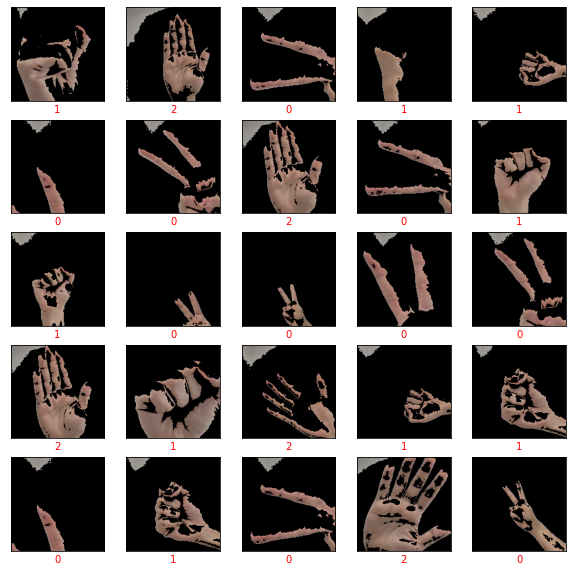

In [11]:
image_show()

현재 image의 크기는 (224, 224)이다. 이는 학습시키는 데 오래걸린 뿐더러 Conv 연산을 수행하는 것은 이미지의 크기가 작더라도 괜찮다고.. @진환님께서 이야기해주셨다 ㅎㅎ. (조금 더 공부해보자). 그래서 학습 효율이 가장 좋다는 2의 제곱수 형태로 변환할 것이다. 128x128

In [12]:
def preprocessing(image):
    # 필요하다면 전처리를 한다고 했던 부분이다.
    
    # BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # hand bitwise
    lower_hand = np.array([110,90,80])
    upper_hand = np.array([190,160,150])

    mask = cv2.inRange(image, lower_hand, upper_hand)

    image = cv2.bitwise_and(image, image, mask=mask)
    
    # image crop
    image = image[30:190, 30:190]
    
    # image resize
    image = cv2.resize(image, (128, 128))
    return image

마지막으로, 단조로운 손 이미지 데이터에 3개의 RGB 채널은 불필요할 수 있겠다는 생각을 했다.

In [13]:
def preprocessing(image):
    # 필요하다면 전처리를 한다고 했던 부분이다.
    
    # BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # hand bitwise
    lower_hand = np.array([110,90,80])
    upper_hand = np.array([190,160,150])

    mask = cv2.inRange(image, lower_hand, upper_hand)

    image = cv2.bitwise_and(image, image, mask=mask)
    
    # image crop
    image = image[30:190, 30:190]
    
    # image resize
    image = cv2.resize(image, (128, 128))
    
    # RGB to GRAY
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

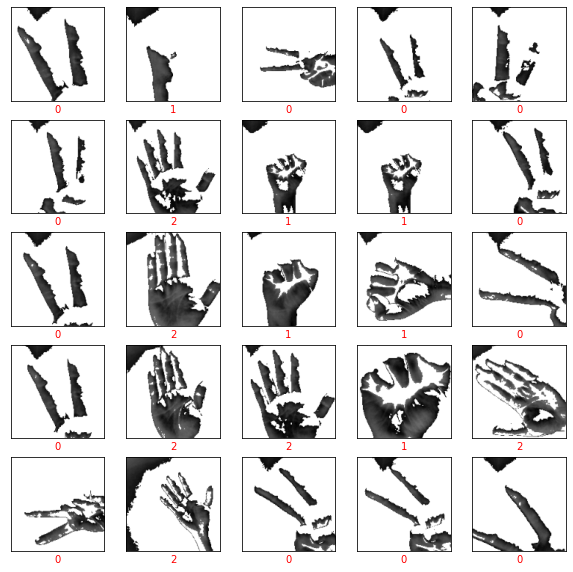

In [14]:
image_show()

데이터에 관련한 하나의 큰 과제가 남아있다.

### 테스트 데이터로 이미지 전처리 한 뒤 결과 살펴보기

위의 이미지 데이터에서 `train_test_split` 을 하고 test accuracy를 찍어보면 충분히 좋은 결과가 나온다. 하지만 이 노드에서의 과제의 중점은 다른 환경에서 다른 누군가가 찍은 가위바위보 데이터도 분류할 수 있는 모델을 만드는 것이라 생각한다. 그래서 지금까지의 processing에 문제가 있을 수 있고 수정이 필요할 수 있다. 번거롭지만 확인해봐야 한다.

나는 학습에 사용한 태경님 데이터를 포함한 11명의 데이터를 가지고있다. 그러니까 태경님의 데이터를 제외한 데이터를 전부 한곳으로 모아보겠다.

In [15]:
print(os.listdir('data_all_users'))

['승민', '재성', '태경', '경은', '준일', '용협', '수완', '.ipynb_checkpoints', '지윤', '은서', '진환', '호성']


In [16]:
test_users = [user for user in os.listdir('data_all_users') if user != '태경' and not user.startswith('.')]
test_users

['승민', '재성', '경은', '준일', '용협', '수완', '지윤', '은서', '진환', '호성']

In [17]:
test_data = [load_data(os.path.join('data_all_users', test_user)) for test_user in test_users]
test_x  = [data[0] for data in test_data]
test_y = [data[1] for data in test_data]
test_x = np.concatenate(test_x)
test_y = np.concatenate(test_y)


In [18]:
test_x.shape

(3030, 128, 128)

총 3030개의 test 데이터가 모아진 것을 확인할 수 있다.<br/>
또한, 앞서 정의한 `load_data()` 로 데이터를 불러왔기 때문에 channel이 제거된 shape을 볼 수 있다. 결과를 확인해보자.

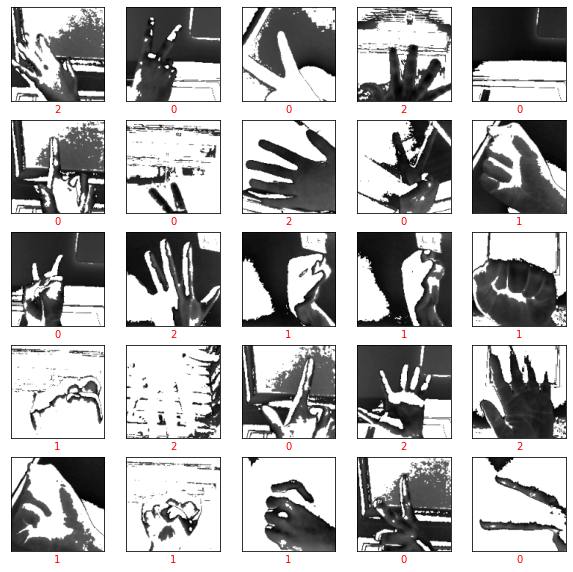

In [19]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    rand = np.random.choice(range(len(test_x)))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_x[rand], cmap=plt.cm.binary)
    plt.xlabel(test_y[rand], color='red')
plt.show()

나름대로 만족하기 때문에 마지막으로 train 데이터를 한번 불러와주고 나는 아래의 학습에서 CNN 모델을 사용할 것이기 때문에 channel을 추가해줘야 한다.

In [20]:
image_dir_path = './data_all_users/준일/'
train_x, train_y = load_data(image_dir_path)

train_x = train_x.reshape(-1, 128, 128, 1)
test_x = test_x.reshape(-1, 128, 128, 1)

print(f"train x : {train_x.shape} train y : {train_y.shape}")
print(f"test x : {test_x.shape} test y : {test_y.shape}")

train x : (300, 128, 128, 1) train y : (300,)
test x : (3030, 128, 128, 1) test y : (3030,)


## 2. 모델 정의 및 학습

In [21]:
# SEED 값을 고정함으로써 온전히 사용자 지정 값이 모델의 결과에 영향을 끼치도록 하였다.
tf.random.set_seed(777)

In [22]:
IMG_SHAPE = (128, 128, 1)
 
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMG_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
model.fit(train_x, train_y, epochs=5)

Epoch 1/5
10/10 [==============================] - 3s 263ms/step - loss: 1.0152 - accuracy: 0.3367
Epoch 2/5
10/10 [==============================] - 3s 253ms/step - loss: 0.7823 - accuracy: 0.4633
Epoch 3/5
10/10 [==============================] - 3s 257ms/step - loss: 0.6236 - accuracy: 0.8533
Epoch 4/5
10/10 [==============================] - 3s 253ms/step - loss: 0.4202 - accuracy: 0.9867
Epoch 5/5
10/10 [==============================] - 3s 261ms/step - loss: 0.3482 - accuracy: 0.9933


In [24]:
loss, acc = model.evaluate(test_x, test_y)

print("Model loss : {:.4f} Model acc : {:.4f}".format(loss, acc))

95/95 [==============================] - 6s 62ms/step - loss: 7.9805 - accuracy: 0.4403
Model loss : 7.9805 Model acc : 0.4403


약 45%의 Accuracy가 나왔다. 적절한 하이퍼 파라미터를 찾는 과정을 통해 학습의 정확도를 올려보자.

---
## 3. 하이퍼 파라미터 튜닝

`Conv2D` 의 첫번째 인자, `Dense` 의 첫번째 인자는 대상 Layer의 출력 채널수를 의미한다. 이는 전체 model의 파라미터 수에 직접적인 영향을 끼친다. 적절한 하이퍼 파라미터를 찾아보자.

In [25]:
conv_channel_1 = [32, 64, 128]
conv_channel_2 = [32, 64, 128]
dense_channel_1 = [16, 32, 64, 128]
dense_channel_2 = [16, 32, 64]

List의 조합을 위해서 4중 for 문을 사용하려 했는데 다행히도 `itertools`에서 `product` 라는 메소드를 통해 쉽게 리스트의 조합을 만들 수 있었다.

In [26]:
from itertools import product

def get_model():
    parameters = product(conv_channel_1, conv_channel_2, dense_channel_1, dense_channel_2)
    for args in parameters:
        model=tf.keras.models.Sequential()
        model.add(tf.keras.layers.Conv2D(args[0], (3,3), activation='relu', input_shape=IMG_SHAPE))
        model.add(tf.keras.layers.MaxPooling2D(2,2))
        model.add(tf.keras.layers.Conv2D(args[1], (3,3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2)))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(args[2], activation='relu'))
        model.add(tf.keras.layers.Dense(args[3], activation='relu'))
        model.add(tf.keras.layers.Dense(3, activation='softmax'))
        
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        yield model, args

In [ ]:
import time


best_test_acc = 0
best_args = []
start_time = time.time()

for model, args in get_model():
    
    model.fit(train_x, train_y, epochs=5)
    
    loss, acc = model.evaluate(test_x, test_y)
    print("Test Loss : {:.4f}, Test Acc : {:.4f}".format(loss, acc))
    if acc > best_test_acc:
        print("BEST!!!")
        best_test_acc = acc
        best_args = args
        
print(f"best Acc : {best_test_acc}, n_channel_1 : {args[0]}, n_channel_2 : {args[1]}, n_dense_1 : {args[2]}, n_dense_2 : {args[3]}")
print("spend : ", time.time() - start_time)

하이퍼 파라미터 튜닝을 통해 얻은 결과는 다음과 같다. 지면의 길이가 너무 길어 출력을 생략하였다. 

- best acc : 0.4749175012111664
- n_channel_1 : 128
- n_channel_2 : 128
- n_dense_1 : 128
- n_dense_2 : 64

## 4. 결론

1명의 Train 데이터로 10명의 데이터를 한번에 묶어 테스트했기 때문에 높은 성능이 있을거라 생각지는 않았지만 사실 47.5%의 accuracy는 아쉬운 결과이다. 조금 더 이미지를 잘 처리하고 더 다양한 하이퍼 파라미터들을 수정했다면 좋은 성능이 나올수도 있을것이다.
